In [2]:
!ls

DNN_model  README.md  classify.ipynb  fronted  gesture	infer.py  utils.py


In [3]:
import paddle
import paddle.fluid as fluid
import numpy
from __future__ import print_function
try:
    from paddle.fluid.contrib.trainer import *
    from paddle.fluid.contrib.inferencer import *
except ImportError:
    print("Import error")
    from paddle.fluid.trainer import *
    from paddle.fluid.inferencer import *

import numpy as np
import paddle
import paddle.fluid as fluid
import os
from PIL import Image, ImageOps
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

## 1 - 配置网络结构

In [4]:
IMAGE_WIDTH, IMAGE_HEGHT = 64,64

In [5]:
def softmax_regression():
    """
    定义softmax分类器：
        只通过一层简单的以softmax为激活函数的全连接层，可以得到分类的结果
    Args:
        img -- 输入的原始图像数据
    Return:
        predict_image -- 分类的结果
    """
    img = fluid.layers.data(
        name='img', shape =[1,IMAGE_WIDTH,IMAGE_HEGHT],dtype = 'float32')
    predict = fluid.layers.fc(input=img, size=10, act='softmax')
    return predict
 

In [6]:
def multilayer_perceptron():
    """
    定义多层感知机分类器：
        含有两个隐藏层（即全连接层）的多层感知器
        其中两个隐藏层的激活函数均采用 ReLU，输出层的激活函数用 Softmax
    Args:
        img -- 输入的原始图像数据
    Return:
        predict_image -- 分类的结果
    """
    
    img = fluid.layers.data(
        name='img', shape =[1,IMAGE_WIDTH,IMAGE_HEGHT],dtype = 'float32')
    # 第一个全连接层，本层神经元有128个 激活函数为 ReLU 
    hidden1 = fluid.layers.fc(input=img, size=128, act='relu')
    
    # 第二个全连接层，本层神经元有64个 激活函数为 ReLU 
    hidden2 = fluid.layers.fc(input=hidden1, size=64, act='relu')
    
    # 以 softmax 为激活函数的全连接输出层，输出层的大小必须为 10,对应 0-9 这 10 个数字
    predict = fluid.layers.fc(input=hidden2, size=10, act='softmax')
    return predict


In [23]:

def convolutional_neural_network():
    """
    定义卷积神经网络分类器：
        输入的二维图像，经过两个卷积-池化层，使用以softmax为激活函数的全连接层作为输出层
    Args:
        img -- 输入的原始图像数据
    Return:
        predict -- 分类的结果
    """
    img = fluid.layers.data(
        name='img', shape =[1,IMAGE_WIDTH,IMAGE_HEGHT],dtype = 'float32')
    # 第一个卷积-池化层
    # 基本设置参考： filter 的数量 20
    conv_pool1 = fluid.nets.simple_img_conv_pool(input=img, 
                                             num_filters=20, 
                                             filter_size=5, 
                                             pool_size=2, 
                                             pool_stride=2, 
                                             pool_padding=0,
                                             act='relu')


    
    # 第二个卷积-池化层
    # 基本设置参考： filter 的数量 50
    conv_pool2 = fluid.nets.simple_img_conv_pool(input=conv_pool1, 
                                             num_filters=20, 
                                             filter_size=5, 
                                             pool_size=2, 
                                             pool_stride=2, 
                                             pool_padding=0,
                                             act='relu')
    
    
    
    
    # 以softmax为激活函数的全连接输出层，输出层的大小必须为10,对应0-9这10个数字
    predict = fluid.layers.fc(input=conv_pool2, size=10, act='softmax')
    
    return predict


## 2 - 定义数据加载

In [8]:
def load_image(filename):
    """
    定义读取输入图片的函数：
        读取指定路径下的图片，将其处理成分类网络输入数据对应形式的数据，如数据维度等
    Args:
        file -- 输入图片的文件路径
    Return:
        im -- 分类网络输入数据对应形式的数据
    """
    # 可以改进的地方
    # 图片增强，旋转，RGB三通道
    im = Image.open(filename).convert('L')

    im = im.resize((IMAGE_WIDTH,IMAGE_HEGHT), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, IMAGE_WIDTH,IMAGE_HEGHT).astype(np.float32)
    im = im / 255.0 * 2.0 - 1.0
    return im


In [9]:
def train_data_reader():
    def reader():
        buffer_size = 100
        for dirpath, dirnames, filenames in os.walk('./gesture/train/'):
#             label = dirpath.split('/')[-1]
            for filename in filenames:
                if filename[0] == '.':
                    continue
                label = filename.split('.')[-2][-1]
                images = load_image(os.path.join(dirpath, filename))
                yield images, int(label)
#                 for img in images:
#                     yield img,int(label)
    return reader

In [10]:
def test_data_reader():
    def reader():
        buffer_size = 100
        for dirpath, dirnames, filenames in os.walk('./gesture/test/'):
            label = dirpath.split('/')[-1]
            for filename in filenames:
                if filename[0] == '.':
                    continue
                images = load_image(os.path.join(dirpath, filename))
                yield images, int(label)
#                 for i in range(buffer_size):
#                     yield images[i, :], int(label)
    return reader


## 3 - 训练过程

在构建完成分类器后，接下来进入模型的训练过程，一般步骤如下：

- 设置训练场所
- 配置网络结构和优化方法
    - 配置网络结构
    - 定义损失函数 cost
    - 定义优化器 optimizer
- 训练准备
    - 定义输入数据与网络的映射关系
    - 定义文件路径
    - 事件处理函数
    - 定义执行器
        - 初始化网络参数
- 模型训练
    - 定义 reader
    - 定义 trainer 
    - 开始训练


### ** （1）设置训练场所 **

首先进行设置训练使用的设备。在复杂量较低的时候使用 CPU 就可以完成任务，但是对于大规模计算就需要使用 GPU 训练。目前 GPU 训练都是基于 CUDA 工具之上的。
- use_cuda=False 表示不使用 GPU 进行训练

In [11]:
# 设置训练场所
use_cuda = False
# use_cuda = True
place = fluid.CUDAPlace(1) if use_cuda else fluid.CPUPlace()

### ** （2）配置网络结构和优化方法 **
这一阶段，我们关注的是网络拓扑结构的配置和优化方法的配置

** 网络结构 **  
接下来需要配置分类网络的结构，首先通过 layers.data 配置数据输入层，然后配置分类器（代码中提供了三个不同的分类器，每次使用选择其中一个，注释掉其余两个即可）。例如下方代码中选用的是卷积神经网络分类器。  
然后设置损失函数，对于分类问题常常选择交叉熵损失函数。  


In [12]:
def train_func():
    """
    配置网络结构
    Args:
    Return:
        label -- 标签数据
        predict -- 输出层
        cost -- 损失函数
        optimizer -- 优化器
    """
    """
    标签层:
        name=’label’：名称为label,对应输入图片的类别标签
    """
    label = fluid.layers.data(name='label', shape = [1],dtype = 'int64')


    """ 
    选择分类器：
        在此之前已经定义了3种不同的分类器，在下面的代码中,
        我们可以通过保留某种方法的调用语句、注释掉其余两种，以选择特定的分类器
    """
#     predict = softmax_regression()
#     predict = multilayer_perceptron()
    predict = convolutional_neural_network()

    # 损失函数，cross_entropy 函数内部使用交叉熵损失函数
    cost = fluid.layers.cross_entropy(input=predict, label=label)
    avg_cost = fluid.layers.mean(cost)
    return avg_cost



** optimizer **  

1. 创建优化器 
这里可以尝试采用 Momentum 或 Adam 优化器。 

2. 使用优化器  
- 训练过程在更新权重时采用动量优化器 `Momentum` ，Momentum是为了让目标函数沿梯度方向快速收敛的一种加速学习方法，其中参数 0.9 代表动量优化每次保持前一次速度的 0.9 倍。
- 训练速度（learning_rate）： 迭代的速度，与网络的训练收敛速度有关系。


** 练习： **
1. 创建Adam优化器并且设置参数值：learning_rate=0.2, beta1=0.9, beta2=0.999 和 epsilon=1e-08

> **API解释**  
> **动量** 通常写法：optimizer = fluid.optimizer.Momentum(learning_rate= 0.1 , momentum= 0.9)  
>API 参考地址：http://www.paddlepaddle.org/docs/0.14.0/api/fluid/en/optimizer.html#permalink-9-momentumoptimizer

** \*\*特别的\*\* **  
由于本例使用 trainer 的写法，所以需要将优化器包装到函数中方便后面使用。  


In [13]:
def optimizer_func():
    # 创建优化器optimizer，下面列举了2种常用的优化器，不同类型优化器选一即可
    # 创建Momentum优化器，并设置学习率(learning_rate)、动量(momentum)
    ### 练习代码开始处 ### （1-3行代码）
    optimizer = fluid.optimizer.Momentum(learning_rate=0.1 , momentum=0.9)
#     optimizer = fluid.optimizer.SGDOptimizer(learning_rate=1e-3)
#     optimizer = fluid.optimizer.Adagrad(learning_rate=1e-2)
    ### 练习代码结束处 ###
    
    return optimizer

### ** （3）训练准备 **
这个阶段我们关注的是小的相关内容的配置。  
** 定义映射 **  
输入网络的数据要与网络本身应该接受的数据相匹配。在 fluid 中使用 feed_order 的概念来保证输入的数据与网络接受的数据的顺序是一致的。本示例中使用 feed_order = ['x', 'label'] 来告知网络，输入的数据是分为两部分，第一部分是 x 值，第二部分是 label 值。

In [14]:
feed_order = ['img', 'label'] 

** 定义文件路径 **  

在 fluid 中，默认模型的相关数据是需要保存在硬盘上的。也就是说在训练阶段会将训练好的模型保存在硬盘上，在将预测阶段可以直接 load 磁盘上的模型数据，进而做出预测。

In [15]:
params_dirname = "./DNN_model"

** 定义事件处理函数 **  
在 fluid 中，如果是用 trainer 的方式来训练的话，那么，在训练的时候允许开发者自己定义事件回调函数。目前接受的事件有 BeginEpochEvent、EndEpochEvent、BeginStepEvent、EndStepEvent。
 用于输出训练过程中 cost 的变化。

In [16]:

# Plot data
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
plot_cost = Ploter(train_title, test_title)

step = 0
# 事件处理
def event_handler_plot(event):
    global step
    if isinstance(event, EndStepEvent):
        if event.step % 2 == 0: # 若干个batch,记录cost
            if event.metrics[0] < 10:
                plot_cost.append(train_title, step, event.metrics[0])
                plot_cost.plot()
        if event.step % 20 == 0: # 若干个batch,记录cost
            test_metrics = trainer.test(
            reader=test_reader, feed_order=feed_order)
            if test_metrics[0] < 10:
                plot_cost.append(test_title, step, test_metrics[0])
                plot_cost.plot()

#             if test_metrics[0] < 1.0:
#                 # 如果准确率达到阈值，则停止训练
#                 print('loss is less than 10.0, stop')
#                 trainer.stop()

        # 将参数存储，用于预测使用
        if params_dirname is not None:
            trainer.save_params(params_dirname)
    step += 1

** 定义执行器 **   
为了能够运行开发者定义的网络拓扑结构和优化器，需要定义执行器。由执行器来真正的执行参数的初始化和网络的训练过程。

In [17]:
# 创建执行器，palce在程序初始化时设定
exe = fluid.Executor(place)
# 初始化执行器
exe.run( fluid.default_startup_program() )

[]

### （4）** 模型训练 **

** 定义reader **   
网络接受的数据实际上是一个又一个的 mini-batch 。 paddle 框架为开发者准备好了 paddle.batch 函数来提供一个又一个 mini-batch。在实际输入数据的时候，我们希望的是数据顺序不要影响网络是训练，paddle 框架也准备了 paddle.reader.shuffle 函数来打乱输入的顺序。 

** 练习： **
设置 BATCH_SIZE 为 10 
> BATCH_SIZE 的大小决定了 每个 mini-batch 中灌入的数据的数量

In [18]:
# 设置 BATCH_SIZE 的大小
### 练习代码开始处 ### (1行代码) 
BATCH_SIZE = 128
### 练习代码结束处 ###

# 设置训练reader
train_reader = paddle.batch(
    paddle.reader.shuffle(
        train_data_reader(), 
        buf_size=500),
    batch_size=BATCH_SIZE)

#设置测试 reader
test_reader = paddle.batch(
    paddle.reader.shuffle(
        test_data_reader(), 
        buf_size=500),
    batch_size=BATCH_SIZE)

** 定义trainer **   
trainer 负责收集训练需要的相关信息。定义 trainer 时需要提供 3个重要信息：
1. 网络拓扑结构，通过参数 train_func 设定
2. 真实训练的设备，通过参数 place 设定
3. 优化方法，通过参数 optimizer_func 设定

In [19]:
#创建训练器
trainer = Trainer(
    train_func= train_func,
    place= place,
    optimizer_func= optimizer_func)


** 开始训练 **  
在做好了所有的准备工作之后，就开始开始训练了。由于本例使用的是 trainer 的方法，所以可以直接调用 trainer 的 train 方法来执行训练。train 方法主要需要设置3个参数： reader、num_epochs 和 feeder_order。
其中，  
>reader 表示能够持续提供 mini-batch 的数据源  
>num_epochs 表示所有的数据将要训练多少轮次（就是一个数字）  
>feeder_order 表示数据的顺序。

我们注意到，reader 和 feeder_order 在前面的准备过程中已经准备好了。 除了这三个参数外，train 还接受一个 event_handler 参数。这个参数允许开发者自己定义回调函数，用以在训练过程中打印训练相关的信息，甚至在合适的时候停止训练。  
函数的形式如下：
```
trainer.train(
    reader= ,
    num_epochs= ,
    event_handler= ,
    feed_order= )
```
** 练习： **
1. 编写 train 函数
2. 将 num_epochs 设置为 3

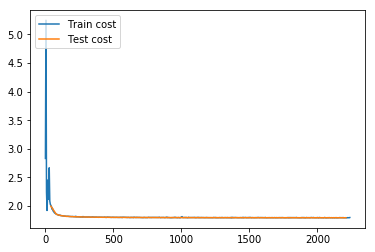

<Figure size 432x288 with 0 Axes>

In [20]:
trainer.train(
    reader=train_reader,
    num_epochs=20,
    event_handler=event_handler_plot,
    feed_order=feed_order)


In [22]:

# 读取并预处理要预测的图片
cur_dir = os.getcwd()
print(cur_dir)
# img = load_image(cur_dir + '/gesture/test/4/21.jpg')
# 设置训练场所
use_cuda = False
# use_cuda = True
place = fluid.CUDAPlace(1) if use_cuda else fluid.CPUPlace()

inferencer = Inferencer(
#     infer_func=softmax_regression, # uncomment for softmax regression
#     infer_func=multilayer_perceptron, # uncomment for MLP
    infer_func=convolutional_neural_network,  # uncomment for LeNet5
    param_path=params_dirname,
    place=place )
y_test = []
y_pred = []
test_reader = test_data_reader()
total_count = 0
total_acc = 0.0
for img, label in test_reader():
    y_test.append(label)
    results = inferencer.infer({'img': img})
    lab = np.argsort(results)
    y_pred.append(lab[0][0][-1])
    total_count += 1
    if label == lab[0][0][-1]:
        total_acc += 1
print("total_acc: %f" % (total_acc / total_count))
# print(lab)
# print("Label of image/infer_3.png is: %d" % lab[0][0][-1])
# print(np.mean(y_test==y_pred))


/paddle_train/GestureRecognition
total_acc: 0.166667



## 7 - 总结

通过这个练习我们应该记住：

1. 基于Softmax回归、多层感知器、卷积神经网络构建分类器的操作

2. 如何利用PaddlePaddle的API接口对图片进行特征提取和分类


本教程的softmax回归、多层感知器和卷积神经网络是最基础的深度学习模型，后续章节中复杂的神经网络都是从它们衍生出来的，因此这几个模型对之后的学习大有裨益。同时，我们也观察到从最简单的softmax回归变换到稍复杂的卷积神经网络的时候，MNIST数据集上的识别准确率有了大幅度的提升，原因是卷积层具有局部连接和共享权重的特性。在之后学习新模型的时候，希望大家也要深入到新模型相比原模型带来效果提升的关键之处。作为扩展，大家可以用自己的数据，定义自己的网络模型，并完成自己的训练和预测任务。


## 参考文献

1. LeCun, Yann, Léon Bottou, Yoshua Bengio, and Patrick Haffner. ["Gradient-based learning applied to document recognition."](http://ieeexplore.ieee.org/abstract/document/726791/) Proceedings of the IEEE 86, no. 11 (1998): 2278-2324.
2. Wejéus, Samuel. ["A Neural Network Approach to Arbitrary SymbolRecognition on Modern Smartphones."](http://www.diva-portal.org/smash/record.jsf?pid=diva2%3A753279&dswid=-434) (2014).
3. Decoste, Dennis, and Bernhard Schölkopf. ["Training invariant support vector machines."](http://link.springer.com/article/10.1023/A:1012454411458) Machine learning 46, no. 1-3 (2002): 161-190.
4. Simard, Patrice Y., David Steinkraus, and John C. Platt. ["Best Practices for Convolutional Neural Networks Applied to Visual Document Analysis."](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.160.8494&rep=rep1&type=pdf) In ICDAR, vol. 3, pp. 958-962. 2003.
5. Salakhutdinov, Ruslan, and Geoffrey E. Hinton. ["Learning a Nonlinear Embedding by Preserving Class Neighbourhood Structure."](http://www.jmlr.org/proceedings/papers/v2/salakhutdinov07a/salakhutdinov07a.pdf) In AISTATS, vol. 11. 2007.
6. Cireşan, Dan Claudiu, Ueli Meier, Luca Maria Gambardella, and Jürgen Schmidhuber. ["Deep, big, simple neural nets for handwritten digit recognition."](http://www.mitpressjournals.org/doi/abs/10.1162/NECO_a_00052) Neural computation 22, no. 12 (2010): 3207-3220.
7. Deng, Li, Michael L. Seltzer, Dong Yu, Alex Acero, Abdel-rahman Mohamed, and Geoffrey E. Hinton. ["Binary coding of speech spectrograms using a deep auto-encoder."](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.185.1908&rep=rep1&type=pdf) In Interspeech, pp. 1692-1695. 2010.
8. Kégl, Balázs, and Róbert Busa-Fekete. ["Boosting products of base classifiers."](http://dl.acm.org/citation.cfm?id=1553439) In Proceedings of the 26th Annual International Conference on Machine Learning, pp. 497-504. ACM, 2009.
9. Rosenblatt, Frank. ["The perceptron: A probabilistic model for information storage and organization in the brain."](http://psycnet.apa.org/journals/rev/65/6/386/) Psychological review 65, no. 6 (1958): 386.
10. Bishop, Christopher M. ["Pattern recognition."](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) Machine Learning 128 (2006): 1-58.
11. http://ufldl.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/
